In [1]:
#pip install sklearn

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import confusion_matrix

In [3]:
data = pd.read_csv('Comune-di-Milano-Strutture-ricettive-alberghiere.csv',sep=';',encoding='unicode_escape')
data.head()

,Ubicazione,Tipo via,Descrizione via,Civico,Codice via,ZD,Camere,Camere piano,Categoria,Insegna,Piani totali,Piano piano,Posti letto,Posti letto per piano,Tipo attività struture extra
0,ALZ NAVIGLIO GRANDE N. 8 (z.d. 6),ALZ,NAVIGLIO GRANDE,8.0,5144.0,6.0,14.0,NaN,4,HOTEL MAISON BORELLA,NaN,NaN,25.0,NaN,Albergo
1,codvia 0000 num.024 ; (),NaN,NaN,NaN,NaN,NaN,259.0,259,4,radisson blu hotel milan,NaN,NaN,518.0,518,Albergo
2,CSO BUENOS AIRES N. 18 (z.d. 3),CSO,BUENOS AIRES,18.0,2129.0,3.0,16.0,16,1,hotel aurora,1.0,1,25.0,25,Albergo
3,CSO BUENOS AIRES N. 26 (z.d. 3),CSO,BUENOS AIRES,26.0,2129.0,3.0,25.0,NaN,3,hotel buenos aires,NaN,NaN,39.0,NaN,Albergo
4,CSO BUENOS AIRES N. 2 (z.d. 3),CSO,BUENOS AIRES,2.0,2129.0,3.0,46.0,15;11;8,3,albergo fenice,4.0,1;2;3;4,98.0,24;19;13,Albergo


# Data profiling

# Data cleaning

## Formatting and normalization

In [4]:
#Change column names
data=data.rename(columns={"Descrizione via":"Nome via", "ZD":"Municipio", "Camere":"Camere tot", 
                          "Camere piano":"Camere per piano", "Categoria":"Numero stelle", "Insegna":"Nome",
                          "Piano piano": "Elenco piani", "Posti letto":"Posti letto tot",
                          "Tipo attività struture extra":"Tipologia"})

In [5]:
# Make all strings uppercase
data["Nome"] = data["Nome"].str.upper()
data["Nome via"] = data["Nome via"].str.upper()
data["Ubicazione"] = data["Ubicazione"].str.upper()
data["Tipo via"] = data["Tipo via"].str.upper()
print(data["Tipologia"].unique())
data["Tipologia"] = data["Tipologia"].str.upper() #Tipologia goes from three categories to two just by changing to uppercase
print(data["Tipologia"].unique())

['Albergo' 'Residence' nan 'albergo']
['ALBERGO' 'RESIDENCE' nan]


In [6]:
print(data["Numero stelle"].unique())
data.loc[data['Numero stelle'] == '5 STELLE LUSSO', 'Numero stelle'] = '6'
data.loc[data['Numero stelle'] == 'I', 'Numero stelle'] = np.nan
data.loc[data['Numero stelle'] == 'l', 'Numero stelle'] = np.nan
data["Numero stelle"] = data["Numero stelle"].astype("Int64")
data["Numero stelle"].unique()

['4' '1' '3' '5' nan 'l' '2' 'I' '5 STELLE LUSSO']


<IntegerArray>
[4, 1, 3, 5, <NA>, 2, 6]
Length: 7, dtype: Int64

In [7]:
# Posti letto per piano and Camere per piano have a lot of null values and are inconsistent with Camere tot and Posti letto tot, so we can drop the column
data = data.drop(["Posti letto per piano"], axis = 1)
data = data.drop(["Camere per piano"], axis = 1)

In [8]:
data[data["Elenco piani"].notna()]

,Ubicazione,Tipo via,Nome via,Civico,Codice via,Municipio,Camere tot,Numero stelle,Nome,Piani totali,Elenco piani,Posti letto tot,Tipologia
2,CSO BUENOS AIRES N. 18 (Z.D. 3),CSO,BUENOS AIRES,18.0,2129.0,3.0,16.0,1,HOTEL AURORA,1.0,1,25.0,ALBERGO
4,CSO BUENOS AIRES N. 2 (Z.D. 3),CSO,BUENOS AIRES,2.0,2129.0,3.0,46.0,3,ALBERGO FENICE,4.0,1;2;3;4,98.0,ALBERGO
6,CSO BUENOS AIRES N. 3 (Z.D. 3),CSO,BUENOS AIRES,3.0,2129.0,3.0,116.0,4,CRISTOFORO COLOMBO,4.0,2;3;4;5,191.0,ALBERGO
12,CSO EUROPA N. 9 (Z.D. 1),CSO,EUROPA,9.0,300.0,1.0,89.0,4,HOTEL GALILEO,7.0,1;2;3;4;5;6;7,159.0,ALBERGO
14,CSO GARIBALDI GIUSEPPE N. 84 (Z.D. 1),CSO,GARIBALDI GIUSEPPE,84.0,1010.0,1.0,98.0,4,CARLYLE BRERA HOTEL,7.0,1;2;3;4;5;6;7,203.0,ALBERGO
...,...,...,...,...,...,...,...,...,...,...,...,...,...
443,VLE SUZZANI GIOVANNI NUM.013/15 ; (Z.D. 9),NaN,NaN,NaN,NaN,NaN,131.0,3,HOTEL IBIS MILANO CA GRANDA,4.0,1;2;3;4,262.0,ALBERGO
444,VLE TESTI FULVIO N. 300 (Z.D. 9),VLE,TESTI FULVIO,300.0,1441.0,9.0,140.0,4,STARHOTELS TOURIST,NaN,R;1;2;3;4;5,250.0,ALBERGO
446,VLE TUNISIA N. 6 (Z.D. 3),VLE,TUNISIA,6.0,2121.0,3.0,13.0,1,HOTEL KENNEDY,1.0,6,23.0,ALBERGO
447,VLE TUNISIA N. 9 (Z.D. 3),VLE,TUNISIA,9.0,2121.0,3.0,50.0,4,ST. GEORGE HOTEL,NaN,A;1;2;3;4,99.0,ALBERGO


In [9]:
#Elenco piani instead is consistent with Piani totali and can be used to fill some of the Nan in piani totali and then it can be dropped, since it's data are non structured 
count_piani_elenco = data['Elenco piani'].str.split(';').str.len()
data = data.drop(["Elenco piani"], axis = 1)
print(data['Piani totali'].isna().sum())
data['Piani totali'] = data['Piani totali'].fillna(count_piani_elenco)
data['Piani totali'] = data['Piani totali'].astype("Int64")
print(data['Piani totali'].isna().sum())

264
233


Ubicazione doesn't contain null values, so it can be used to fill some of the missing values of columns "Tipo Via", "Nome via", "Civico", "Municipio". 
After being used, this column can be dropped since all the important data are present in other, more structured, columns

In [10]:
Split_tipologia=data.Ubicazione.str.split(' ',n=1,expand=True)
data[['Tipo via 2','Ubi2']]=Split_tipologia
data = data.drop(["Ubicazione"], axis = 1)
data[data["Tipo via"]!=data["Tipo via 2"]] #Check that the old Tipo via is coherent
#Since they are coherent we can fix the null values
data["Tipo via"] = data["Tipo via 2"]
data = data.drop(["Tipo via 2"], axis = 1)
print(data["Tipo via"].unique())
data.loc[data['Tipo via'] == 'CODVIA', 'Tipo via'] = np.nan
print(data["Tipo via"].unique())

['ALZ' 'CODVIA' 'CSO' 'GLL' 'LGO' 'PLE' 'PZA' 'VIA' 'VLE']
['ALZ' nan 'CSO' 'GLL' 'LGO' 'PLE' 'PZA' 'VIA' 'VLE']


In [11]:
delim = ' N. | INT. | NUM.'
Split_nomevia = data.Ubi2.str.split(delim, n=1, expand=True, regex=True)
data[['Nome via 2','Ubi3']]=Split_nomevia
data = data.drop(["Ubi2"], axis = 1)
data[data['Nome via 2']!=data['Nome via']] #They are coherent
data['Nome via']=data['Nome via 2']
data = data.drop(["Nome via 2"], axis = 1)
print(sorted(data["Nome via"].unique()))
data.loc[data['Nome via'] == '0000', 'Nome via'] = np.nan

['0000', 'ABRUZZI', 'AIRAGHI GAETANO', 'AJRAGHI CESARE', 'ALBRICCI ALBERICO', 'ANTONIO DA RECANATE', 'AOSTA', 'ARCHIMEDE', 'ARGONNE', 'ARIMONDI GIUSEPPE', 'ARIOSTO LODOVICO', 'ASPROMONTE', 'ASTOLFO', 'AUGUSTO', 'BAMBAIA', 'BARACCHINI FLAVIO', 'BARTOLOZZI FRANCESCO', 'BASSI UGO', 'BECCARIA CESARE', "BENEFATTORI DELL'OSPEDALE", 'BERENGARIO', 'BLIGNY', 'BONNET NINO', 'BORGONUOVO', 'BORROMEI', 'BOSCOVICH RUGGERO', 'BREMBO', 'BRENTA', 'BRESSANONE', 'BRIVIO CESARE', 'BROGLIO EMILIO', 'BROLETTO', 'BUENOS AIRES', 'BUONARROTI MICHELANGELO', 'BUTTI ENRICO', 'CACCIANINO ANTONIO', 'CADIBONA', 'CALVI PIETRO', 'CANONICA LUIGI', 'CAPPELLINI ALFREDO', 'CARCANO FILIPPO', 'CARDANO GEROLAMO', 'CARROBBIO', 'CASATI FELICE', 'CASELLA GIOVANNI BATTISTA', 'CASTALDI PANFILO', 'CASTELFIDARDO', 'CATALANI ALFREDO', 'CERTOSA', 'CERVA', 'CESARI ANTONIO', 'CESENA', 'CIMAROSA DOMENICO', 'CINQUE GIORNATE', 'COLA MONTANO', 'COLOMBO CRISTOFORO', 'COLOMBO GIUSEPPE', 'COLONNA VITTORIA', 'CONCA DEL NAVIGLIO', 'CONCORDIA', 

In [12]:
Split_civico=data.Ubi3.str.split('Z.D. ',n=1,expand=True)
data[['Civico_2','Ubi4']]=Split_civico
data = data.drop(["Ubi3"], axis = 1)
#print(data["Civico_2"].unique())
delim = ' |/'
Split_civico2=data.Civico_2.str.split(delim,n=1,expand=True)
data[['Civico 3','Ubi5']]=Split_civico2
data = data.drop(["Civico_2"], axis = 1)
data = data.drop(["Ubi5"], axis = 1)
data['Civico 3'] = data['Civico 3'].str.lstrip('0')
print(data["Civico 3"].unique())
data[data["Civico"]!=data["Civico 3"].astype("float64")]
data['Civico']=data['Civico 3'].astype("Int64")
data = data.drop(["Civico 3"], axis = 1)
print(data["Civico"].unique())

['8' '24' '18' '26' '2' '33' '3' '15' '1' '48' '64' '9' '68' '84' '34'
 '11' '4' '74' '61' '78' '19' '69' '91' '32' '43' '55' '5' '10' '12' '14'
 '22' '6' '31' '25' '13' '17' '20' '16' '125' '30' '121' '79' '86' '21'
 '59' '27' '28' '46' '38' '37' '39' '47' '7' '71' '29' '93' '41' '35' '73'
 '49' '40' '50' '117' '278' '77' '45' '83' '90' '371' '60' '153' '132'
 '143' '170' '52' '56' '87' '102' '134' '76' '81' '23' '85' '42' '66' '67'
 '108' '88' '120' '139' '300' '89']
<IntegerArray>
[  8,  24,  18,  26,   2,  33,   3,  15,   1,  48,  64,   9,  68,  84,  34,
  11,   4,  74,  61,  78,  19,  69,  91,  32,  43,  55,   5,  10,  12,  14,
  22,   6,  31,  25,  13,  17,  20,  16, 125,  30, 121,  79,  86,  21,  59,
  27,  28,  46,  38,  37,  39,  47,   7,  71,  29,  93,  41,  35,  73,  49,
  40,  50, 117, 278,  77,  45,  83,  90, 371,  60, 153, 132, 143, 170,  52,
  56,  87, 102, 134,  76,  81,  23,  85,  42,  66,  67, 108,  88, 120, 139,
 300,  89]
Length: 92, dtype: Int64


In [13]:
data["Municipio 2"]=data["Ubi4"].str.slice(0,1)
data = data.drop(["Ubi4"], axis = 1)
print(data["Municipio 2"].unique())
data[data["Municipio"].astype(str)!=data["Municipio 2"]] #Check that the old Tipo via is coherent
#There are some inconsistencies, we decided to keep the one coming from Ubicazione
data["Municipio"]=data["Municipio 2"].astype("float64").astype("Int64")
data = data.drop(["Municipio 2"], axis = 1)
print(data["Municipio"].unique())

['6' None '3' '1' '5' '4' '8' '7' '9' '2']
<IntegerArray>
[6, <NA>, 3, 1, 5, 4, 8, 7, 9, 2]
Length: 10, dtype: Int64


In [14]:
data["Codice via"]=data["Codice via"].astype("Int64")
data["Camere tot"]=data["Camere tot"].astype("Int64")
data["Piani totali"]=data["Piani totali"].astype("Int64")
data["Posti letto tot"]=data["Posti letto tot"].astype("Int64")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 451 entries, 0 to 450
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Tipo via         450 non-null    object
 1   Nome via         450 non-null    object
 2   Civico           451 non-null    Int64 
 3   Codice via       437 non-null    Int64 
 4   Municipio        443 non-null    Int64 
 5   Camere tot       450 non-null    Int64 
 6   Numero stelle    438 non-null    Int64 
 7   Nome             441 non-null    object
 8   Piani totali     218 non-null    Int64 
 9   Posti letto tot  450 non-null    Int64 
 10  Tipologia        441 non-null    object
dtypes: Int64(7), object(4)
memory usage: 42.0+ KB


In [15]:
#reorder the rows in the table
col = 'Numero stelle'
cols = [col] + [c for c in data.columns if c != col]
data = data[cols]
col = 'Tipologia'
cols = [col] + [c for c in data.columns if c != col]
data = data[cols]
col = 'Nome'
cols = [col] + [c for c in data.columns if c != col]
data = data[cols]
data = data.sort_values(by ='Nome',ascending=True)
data.head()

,Nome,Tipologia,Numero stelle,Tipo via,Nome via,Civico,Codice via,Municipio,Camere tot,Piani totali,Posti letto tot
244,ACCA PALACE,RESIDENCE,4,VIA,NICOTERA GIOVANNI,9,1508,9,41,<NA>,82
412,ALBERGO ACCURSIO,ALBERGO,3,VLE,CERTOSA,88,7174,8,27,<NA>,39
353,ALBERGO DEL SOLE,ALBERGO,1,VIA,SPONTINI GASPARE,6,2141,3,17,2,40
104,ALBERGO FELICE CASATI,ALBERGO,4,VIA,CASATI FELICE,18,2122,3,99,3,145
4,ALBERGO FENICE,ALBERGO,3,CSO,BUENOS AIRES,2,2129,3,46,4,98


## Nan filling

In [16]:
# Since the only row with Camete tot Nan has also Posti letto tot Nan and Nome Nan we decided to drop it
print(data[data["Camere tot"].isna()])
data = data.dropna(subset=['Camere tot'])

    Nome Tipologia  Numero stelle Tipo via         Nome via  Civico  \
322  NaN       NaN           <NA>      VIA  SANTA RADEGONDA      14   

     Codice via  Municipio  Camere tot  Piani totali  Posti letto tot  
322        <NA>          1        <NA>          <NA>             <NA>  


In [17]:
data[data["Tipologia"].isna()]

,Nome,Tipologia,Numero stelle,Tipo via,Nome via,Civico,Codice via,Municipio,Camere tot,Piani totali,Posti letto tot
344,EUROHOTEL,NaN,3,VIA,SIRTORI GIUSEPPE,24,2180,3,60,<NA>,101
440,HOTEL ARCO ROMANA,NaN,2,VLE,SABOTINO,16,4046,5,13,<NA>,25
109,HOTEL BAVIERA,NaN,4,VIA,CASTALDI PANFILO,7,2119,2,52,4,92
30,HOTEL CITY,NaN,4,GLL,BUENOS AIRES,5,2146,3,60,7,100
292,HOTEL ETRUSCO,NaN,3,VIA,PORPORA NICOLA ANTONIO,56,2229,3,18,4,21
346,HOTEL SOPERGA,NaN,3,VIA,SOPERGA,24,2262,2,78,<NA>,134
349,HOTEL TECO,NaN,3,VIA,SPALLANZANI LAZZARO,27,2153,3,28,<NA>,80
182,LA CARAVELLA,NaN,2,VIA,HAJECH CAMILLO,18,3091,4,11,<NA>,16
249,MERCURE HOTEL,NaN,4,VIA,ORSEOLO PIETRO,1,5113,6,59,<NA>,101


In [18]:
condition = data["Nome"].str.contains("HOTEL", case=False, na=False)
data.loc[condition, "Tipologia"] = "ALBERGO"
condition = data["Nome"].str.contains("RESIDENCE", case=False, na=False)
data.loc[condition, "Tipologia"] = "RESIDENCE"
data[data['Tipologia'].isna()]
#One remains, it can be fill with the mode value
data['Tipologia']=data['Tipologia'].fillna(data['Tipologia'].mode().values[0])

In [19]:
data[data["Nome"].isna()]
#Names cannot be predicted, we decided to fill with unknowns
data['Nome']=data['Nome'].fillna('Unknown')

In [20]:
data[data["Municipio"].isna()]

,Nome,Tipologia,Numero stelle,Tipo via,Nome via,Civico,Codice via,Municipio,Camere tot,Piani totali,Posti letto tot
33,HOTEL ARISTON,ALBERGO,3,LGO,CARROBBIO,2,542,<NA>,52,6,95
88,HOTEL ARIZONA,ALBERGO,4,VIA,BRESSANONE,4,7425,<NA>,80,5,120
71,HOTEL DELIZIA,ALBERGO,2,VIA,ARCHIMEDE,86,3086,<NA>,14,2,25
206,IDEA HOTEL MILANO LORENTEGGIO,ALBERGO,4,VIA,LORENTEGGIO,278,<NA>,<NA>,128,<NA>,242
1,RADISSON BLU HOTEL MILAN,ALBERGO,4,NaN,NaN,24,<NA>,<NA>,259,<NA>,518
81,RESIDENCE BONNET,RESIDENCE,2,VIA,BONNET NINO,6,1109,<NA>,19,5,45
392,VISERBA RESIDENCE,RESIDENCE,3,VIA,VISERBA,18,2417,<NA>,47,3,96
355,Unknown,ALBERGO,4,VIA,STEPHENSON GIORGIO,55,<NA>,<NA>,256,<NA>,512


In [21]:
key_cols = ["Tipo via", "Nome via"]
municipio = data.groupby(key_cols)["Municipio"].transform('first')
#Fill missing values in municipio if the ase some streets that are the same
data["Municipio"] = data["Municipio"].fillna(municipio)
data[data["Municipio"].isna()]
# 7 nulls remaining, we fill with a standard value 0
data["Municipio"] = data["Municipio"].fillna(0)

In [22]:
data[data["Codice via"].isna()]

,Nome,Tipologia,Numero stelle,Tipo via,Nome via,Civico,Codice via,Municipio,Camere tot,Piani totali,Posti letto tot
24,ENTERPRISE HOTEL,ALBERGO,4,CSO,SEMPIONE,91,<NA>,8,113,<NA>,216
383,HOTEL GRECO,ALBERGO,2,VIA,UGOLINI GIUSEPPE,21,<NA>,9,8,<NA>,20
443,HOTEL IBIS MILANO CA GRANDA,ALBERGO,3,VLE,SUZZANI GIOVANNI,13,<NA>,9,131,4,262
21,HOTEL KING,ALBERGO,4,CSO,MAGENTA,19,<NA>,1,48,6,96
145,HOTEL SAN GUIDO,ALBERGO,3,VIA,FARINI CARLO,1,<NA>,8,31,4,47
268,HOTEL VIRGILIO,ALBERGO,2,VIA,PIERLUIGI GIOVANNI DA PALESTRINA,30,<NA>,2,45,3,63
16,HOTEL ZURIGIO,ALBERGO,3,CSO,ITALIA,11,<NA>,1,39,3,70
206,IDEA HOTEL MILANO LORENTEGGIO,ALBERGO,4,VIA,LORENTEGGIO,278,<NA>,0,128,<NA>,242
272,LOCANDA GELSOMINA,ALBERGO,2,VIA,PIERO DELLA FRANCESCA,4,<NA>,8,10,1,25
190,QUARK DUE,RESIDENCE,4,VIA,LAMPEDUSA,11,<NA>,5,106,7,229


In [23]:
key_cols = ["Tipo via", "Nome via"]
codicevia = data.groupby(key_cols)["Codice via"].transform('first')
#Fill missing values in codicevia if the ase some streets that are the same
data["Codice via"] = data["Codice via"].fillna(codicevia)
data[data["Codice via"].isna()]
# 7 nulls remaining, we fill with a standard value 0000
data["Codice via"] = data["Codice via"].fillna(0000)

In [24]:
data[data["Nome via"].isna()]
#Tipovia and Nomevia cannot be inferred, we put nan
data['Nome via']=data['Nome via'].fillna('Unknown')
data['Tipo via']=data['Tipo via'].fillna('Unknown')


In [25]:
data[data["Numero stelle"].isna()]
#Numero stello would be very difficul to infer from other data, we used -1 to indicate that the value is not known
data['Numero stelle']=data['Numero stelle'].fillna(-1)

In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 450 entries, 244 to 388
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Nome             450 non-null    object
 1   Tipologia        450 non-null    object
 2   Numero stelle    450 non-null    Int64 
 3   Tipo via         450 non-null    object
 4   Nome via         450 non-null    object
 5   Civico           450 non-null    Int64 
 6   Codice via       450 non-null    Int64 
 7   Municipio        450 non-null    Int64 
 8   Camere tot       450 non-null    Int64 
 9   Piani totali     218 non-null    Int64 
 10  Posti letto tot  450 non-null    Int64 
dtypes: Int64(7), object(4)
memory usage: 45.3+ KB


In [27]:
data[data['Piani totali'].isna()]
#we can use machine learning to infer the value

,Nome,Tipologia,Numero stelle,Tipo via,Nome via,Civico,Codice via,Municipio,Camere tot,Piani totali,Posti letto tot
244,ACCA PALACE,RESIDENCE,4,VIA,NICOTERA GIOVANNI,9,1508,9,41,<NA>,82
412,ALBERGO ACCURSIO,ALBERGO,3,VLE,CERTOSA,88,7174,8,27,<NA>,39
191,ALBERGO LARIO,ALBERGO,1,VIA,LARIO,40,1171,9,7,<NA>,17
429,ALBERGO LOMBARDIA,ALBERGO,3,VLE,LOMBARDIA,74,2400,3,96,<NA>,157
339,ALBERGO MARTE,ALBERGO,2,VIA,SFORZA ASCANIO,81,5201,5,15,<NA>,25
...,...,...,...,...,...,...,...,...,...,...,...
185,Unknown,RESIDENCE,2,VIA,IPPODROMO,8,6492,8,116,<NA>,232
248,Unknown,ALBERGO,4,VIA,ORSEOLO PIETRO,1,5113,6,59,<NA>,101
326,Unknown,ALBERGO,4,VIA,SAN TOMASO,8,723,1,11,<NA>,22
355,Unknown,ALBERGO,4,VIA,STEPHENSON GIORGIO,55,0,0,256,<NA>,512


In [28]:
feature="Piani totali"
data["Old_piani_tot"]=data["Piani totali"]
parameters = list(set(["Camere tot", "Posti letto tot", "Numero stelle"]) - set([feature]))

#Create a Linear Regression model to estimate the missing data
model = linear_model.LinearRegression()
model.fit(X = data[parameters].loc[data[feature].notnull()], y = data[feature].loc[data[feature].notnull()])
model_predicted = model.predict(data[parameters].loc[data[feature].isnull()])

rounded_predictions = np.round(model_predicted)
print(feature + " successfully imputed")
data.loc[data[feature].isnull(), feature] = rounded_predictions

Piani totali successfully imputed


In [29]:
y_train_pred = model.predict(data[parameters].loc[data[feature].notnull()])
rounded_predictions = np.round(y_train_pred)
conf_matrix_train = confusion_matrix(data[feature].loc[data[feature].notnull()], rounded_predictions)

print(conf_matrix_train)

[[ 0  0 15  3  0  0  0  0  0  0  0  0  0  0]
 [ 0  5 10  6  0  1  0  0  0  0  0  0  0  0]
 [ 0  0 92 15  7  1  0  0  0  0  0  0  0  0]
 [ 0  0 10 76  7  3  1  0  0  0  0  0  0  0]
 [ 0  0  0  9 56  6  3  0  0  0  0  0  0  0]
 [ 0  0  1  3 15 24  1  0  0  0  1  1  0  0]
 [ 0  0  0  1 10  9 12  1  0  0  1  0  0  0]
 [ 0  0  0  0  4  3  2  6  1  2  0  0  0  0]
 [ 0  0  0  0  3  1  1  1  8  0  0  0  0  0]
 [ 0  0  0  1  0  1  2  0  0  2  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  2  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  0]
 [ 0  0  0  0  0  0  1  0  0  1  0  0  0  0]]


In [30]:
data["Piani totali"].unique()

<IntegerArray>
[5, 4, 2, 3, 6, 7, 1, 11, 8, 10, 9, 12, 17, 13]
Length: 14, dtype: Int64

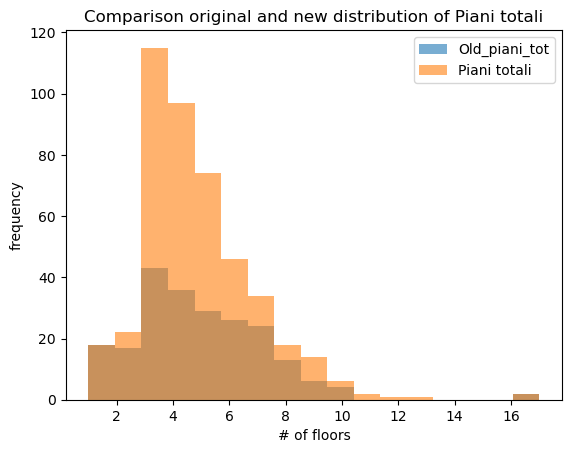

In [31]:
data[["Old_piani_tot","Piani totali"]].plot.hist(
    bins=17,            # Numero di intervalli
    alpha=0.6,          # Trasparenza (cruciale per vedere entrambe le distribuzioni)
    title='Comparison original and new distribution of Piani totali'
)

plt.xlabel('# of floors')
plt.ylabel('frequency')
plt.show()

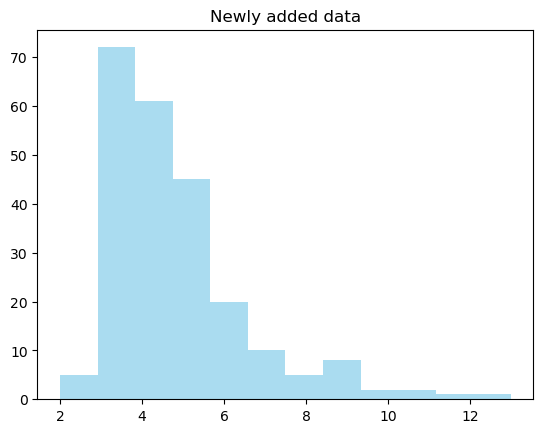

In [32]:
plt.hist(np.round(model_predicted), bins=12, color='skyblue', alpha=0.7)
plt.title('Newly added data')
plt.show()

In [33]:
data = data.drop(["Old_piani_tot"], axis = 1)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 450 entries, 244 to 388
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Nome             450 non-null    object
 1   Tipologia        450 non-null    object
 2   Numero stelle    450 non-null    Int64 
 3   Tipo via         450 non-null    object
 4   Nome via         450 non-null    object
 5   Civico           450 non-null    Int64 
 6   Codice via       450 non-null    Int64 
 7   Municipio        450 non-null    Int64 
 8   Camere tot       450 non-null    Int64 
 9   Piani totali     450 non-null    Int64 
 10  Posti letto tot  450 non-null    Int64 
dtypes: Int64(7), object(4)
memory usage: 45.3+ KB


## Outlier detection

## Data deduplication